In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

# Linear MDPとは？

* [Linear MDP](https://arxiv.org/abs/1907.05388)は特殊な構造をもったMDPです。
* 各状態・行動対に「良い」特徴ベクトルが割り当てられていることを仮定します。
* Linear MDPは線形な関数近似器のもとで非常に効率よく強化学習ができることが知られています。このノートブックではそれを確認します。

---

**定義：Linear MDP**

MDP ($S, A, H, P, r$) が次を満たす$d$次元の特徴マップ $\phi: S \times A \to \mathcal{R}^d$ を持つとき、このMDPをLinear MDPと呼ぶ。

任意の $(s, a) \in S \times A$ について、以下を満たす$S$上の$d$次元(符号付き)測度$\mu$と、未知の$d$次元ベクトル$\theta$が存在する。

$$
P(\cdot | s, a) = \langle \phi(s, a), \mu (\cdot) \rangle,
$$

$$
r(s, a) = \langle \phi(s, a), \theta \rangle
$$

---

なんだか難しいことを言ってる気がしますが、直感的には「MDPの遷移確率$P$と報酬関数$r$を、特徴ベクトル$\phi$が``とても良く表している``」状況になります。

例えば、2つの状態行動と $(s_1, a_1)$と $(s_2, a_2)$ を考えます。そして、その2つの特徴ベクトルがよく似ているとします。つまり、$\phi(s_1, a_1) \approx \phi(s_2, a_2)$ です。

このとき、Linear MDPの定義から、2つの報酬と遷移確率もよく似ていることになります。つまり、$r(s_1, a_1) \approx r(s_2, a_2)$ であり、$P(\cdot | s_1, a_1) \approx P(\cdot | s_2, a_2)$ です。

また、``特徴ベクトルに対して報酬と遷移確率が線形になっている``のがLinear MDPの強力なところです。このとき、線形関数近似でMDPを非常に効率よく解くことができます ([参考文献](https://arxiv.org/abs/1907.05388)の引用論文などを調べてみてください)。

実際に試してみましょう。

# Linear MDPを作ってみる

定義に従って、ランダムなLinear MDPを作ってみます。比較として、ランダムなテーブルMDP (Tabular MDP) も作成します。

In [3]:
def create_features(MDP_type: str, S: int, A: int, d: int):
    """ テーブルMDPかLinear MDPの (特徴ベクトル, 報酬関数, 遷移確率) を作成します

    Args:
        MDP_type (str): "table" or "linear"
        S (int): 状態空間のサイズ
        A (int): 行動空間のサイズ
        gamma (float): 割引率
        d (int): 特徴ベクトルのサイズ

    Returns:
        phi (float): 特徴ベクトル
        rew (float): 報酬関数
        P (float): 遷移確率
    """
    if MDP_type == "table":  # テーブル形式のMDPです

        phi = np.random.randn(S, A, d)  # ランダムな特徴ベクトル
        rew = np.random.rand(S, A)  # ランダムな報酬関数。実験のために0~1に正規化します。
        rew = rew / np.abs(rew).max()

        # ランダムな遷移確率を作ります
        P = np.random.rand(S, A, S)
        P = P / np.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
        assert P.shape == (S, A, S)
        np.testing.assert_almost_equal(P.sum(axis=-1), 1)

    elif MDP_type == "linear":  # Linear MDP

        # 定義中の mu を適当に作り、その後で特徴ベクトルが遷移確率の仮定を満たすように調整します
        mu = np.random.rand(d, S)
        _phi = np.random.rand(S, A, d)
        _P = _phi @ mu
        assert _P.shape == (S, A, S)
        _P_normalize = np.sum(_P, axis=-1, keepdims=True)
        phi = _phi / _P_normalize
        P = phi @ mu
        P = P / P.sum(axis=-1, keepdims=True)
        assert P.shape == (S, A, S)
        np.testing.assert_almost_equal(P.sum(axis=-1), 1)

        # 定義中の theta を適当に作り、報酬関数を作成します。実験のために0~1に正規化します。
        theta = np.random.rand(d)
        _rew = phi @ theta
        _rew_max = np.abs(_rew).max()
        theta = theta / _rew_max
        rew = phi @ theta
        np.testing.assert_almost_equal(np.abs(rew).max(), 1.0)
        assert rew.shape == (S, A)
    
    else:
        raise ValueError

    return jnp.array(phi), jnp.array(rew), jnp.array(P)

In [4]:
# MDPのクラスを作っておきます
from typing import Optional, NamedTuple

class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # ホライゾン
    d: int  # 特徴ベクトルの次元数
    phi: float  # 特徴ベクトル
    rew: float  # 報酬関数
    P: float  # 遷移確率
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    optimal_Q_idx: Optional[np.ndarray] = None  # 後でplot用に使います

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


S = 10
A = 3
S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.99
horizon = int(1 / (1 - gamma))
d = 8

# テーブルMDPを作ります
t_phi, t_rew, t_P = create_features("table", S, A, d)
table_MDP = MDP(S_array, A_array, gamma, horizon, d, t_phi, t_rew, t_P)

# Linear MDPを作ります
l_phi, l_rew, l_P = create_features("linear", S, A, d)
linear_MDP = MDP(S_array, A_array, gamma, horizon, d, l_phi, l_rew, l_P)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# 実験に便利な関数

実験の前に、いくつか便利な関数を導入します。

1. ``compute_greedy_policy``: Q関数 ($S \times A \to \mathcal{R}$) の貪欲方策を返します
2. ``compute_optimal_Q``: MDPの最適Q関数 $q_* : S \times A \to \mathcal{R}$ を返します。
3. ``compute_policy_Q``: 方策 $\pi$ のQ関数 $q_\pi : S \times A \to \mathcal{R}$ を返します。
4. ``compute_optimality_gap``: 方策 $\pi$ と最適解との差 $\|q_* - q_{\pi}\|_\infty$ を返します。この値が小さいほど、$\pi$ はほぼ全ての状態行動対で最適な方策になっています。

In [5]:
from functools import partial


# >>>> 1 >>>>
@jax.jit
def compute_greedy_policy(Q: np.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy
# <<<< 1 <<<<


# >>>> 2 >>>>
@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):

    def backup(optimal_Q):
        greedy_policy = compute_greedy_policy(optimal_Q)
        max_Q = (greedy_policy * optimal_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 100, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)
# <<<< 2 <<<<


# >>>> 3 >>>>
def compute_policy_Q(mdp: MDP, policy: np.ndarray):
    S, A = policy.shape

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 100, body_fn, policy_Q)
# <<<< 3 <<<<

# >>>> 4 >>>>
@jax.jit
def compute_optimality_gap(mdp: MDP, policy: np.ndarray):
    policy_Q = compute_policy_Q(mdp, policy)
    optimality_gap = jnp.abs(mdp.optimal_Q - policy_Q).max()
    return optimality_gap
# <<<< 4 <<<<

最適価値関数はMDPについてただ一つ存在するので、予め計算しておきます。
ついでに、Q値の描画に便利な関数も実装しておきましょう。

* plot_Q: Q値を二次元で描画します。きれいに見えるように、``最適``Q値が大きい順にQ値の状態と行動を並び替えます。plot_Qで右のようなキレイな図が出れば、そのQ関数は最適Qに近いです

/home/toshinori/.cache/pypoetry/virtualenvs/shumi-VTLwuKSy-py3.9/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3471: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


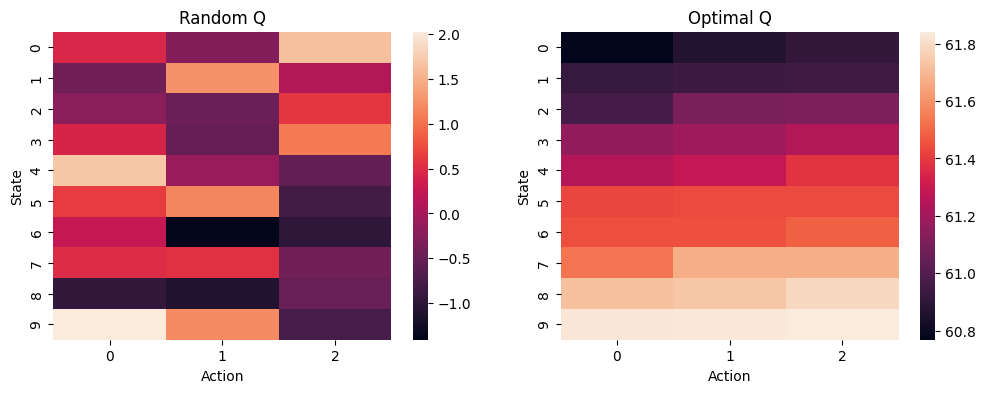

In [6]:
# >>>> optimal Qの計算 >>>>
table_MDP = table_MDP._replace(optimal_Q=compute_optimal_Q(table_MDP))
table_MDP = table_MDP._replace(optimal_Q_idx=np.argsort(table_MDP.optimal_Q.flatten()))  # 描画用
linear_MDP = linear_MDP._replace(optimal_Q=compute_optimal_Q(linear_MDP))
linear_MDP = linear_MDP._replace(optimal_Q_idx=np.argsort(linear_MDP.optimal_Q.flatten()))  # 描画用
# <<<< optimal Qの計算 <<<<



# >>>> Q関数の描画 >>>>
def plot_Q(Q: np.ndarray, mdp: MDP, title: str):
    _Q = Q.flatten()[mdp.optimal_Q_idx]
    sns.heatmap(_Q.reshape(mdp.S, mdp.A))
    plt.xlabel("Action")
    plt.ylabel("State")
    plt.title(title)
# <<<< Q関数の描画 <<<<


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_Q(np.random.randn(S, A), table_MDP, "Random Q")

plt.subplot(1, 2, 2)
plot_Q(table_MDP.optimal_Q, table_MDP, "Optimal Q")

# 動的計画法でMDPを解く

まずは価値反復法と線形関数近似を使った価値反復法でMDPを解いてみましょう。
探索が無くても解けるのか確認するのは常に重要です。

## Tabular Value Iteration

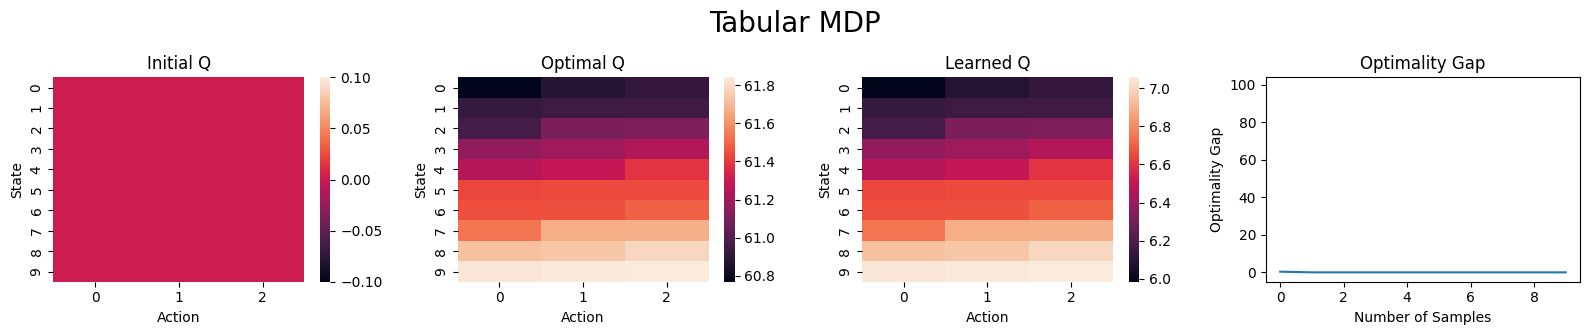

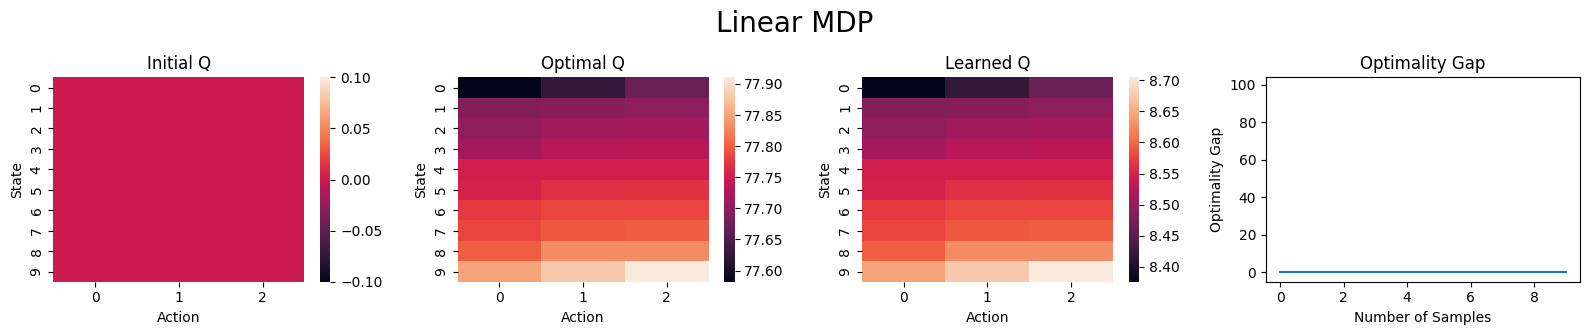

In [7]:
@jax.jit
def compute_targ_Q(mdp: MDP, Q: np.ndarray):
    S, A = Q.shape
    greedy_policy = compute_greedy_policy(Q)
    max_Q = np.sum(greedy_policy * Q, axis=1).reshape(1, 1, S)
    next_v = np.sum(mdp.P * max_Q, axis=-1)
    assert next_v.shape == (S, A)
    return mdp.rew + mdp.gamma * next_v


def do_table_value_iteration(mdp: MDP, title):
    plt.figure(figsize=(16, 3))
    optimality_gaps = []
    
    # >>>> Initialize Q >>>>
    Q_table = np.zeros((mdp.S, mdp.A))
    plt.subplot(1, 4, 1)
    plot_Q(Q_table, mdp, "Initial Q")
    # <<<< Initialize Q <<<<

    # >>>> Do value iteration >>>>
    for _ in range(10):
        Q_table = compute_targ_Q(mdp, Q_table)
        greedy_policy = compute_greedy_policy(Q_table)
        optimality_gaps.append(compute_optimality_gap(mdp, greedy_policy))
    # <<<< Do value iteration <<<<

    # >>>> Plot results >>>>
    plt.subplot(1, 4, 2)
    plot_Q(mdp.optimal_Q, mdp, "Optimal Q")

    plt.subplot(1, 4, 3)
    plot_Q(Q_table, mdp, "Learned Q")

    plt.subplot(1, 4, 4)
    plt.plot(optimality_gaps)
    plt.xlabel("Number of Samples")
    plt.ylabel("Optimality Gap")
    plt.ylim(-5, mdp.horizon + 5)
    plt.title("Optimality Gap")
    # <<<< Plot results <<<<

    plt.tight_layout()
    plt.suptitle(title, y=1.1, fontsize=20)

do_table_value_iteration(table_MDP, "Tabular MDP")
do_table_value_iteration(linear_MDP, "Linear MDP")

## Fitted Value Iteration with Linear Function Approximation

Fitted Value Iterationはこのあたりを参考にしてください：
* [強化学習 (機械学習プロフェッショナルシリーズ)](https://www.amazon.co.jp/%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%83%95%E3%82%A7%E3%83%83%E3%82%B7%E3%83%A7%E3%83%8A%E3%83%AB%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E6%A3%AE%E6%9D%91-%E5%93%B2%E9%83%8E/dp/4065155916/ref=asc_df_4065155916/?tag=jpgo-22&linkCode=df0&hvadid=310429813636&hvpos=&hvnetw=g&hvrand=5738183575122656046&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1009224&hvtargid=pla-675730625220&psc=1&th=1&psc=1)
* [Tree-Based Batch Mode Reinforcement Learning](https://www.jmlr.org/papers/v6/ernst05a.html)

Fitted Value Iterationでは価値反復法のターゲットの値を関数近似器で射影します。この実験で線形近似器の表現力がわかります。

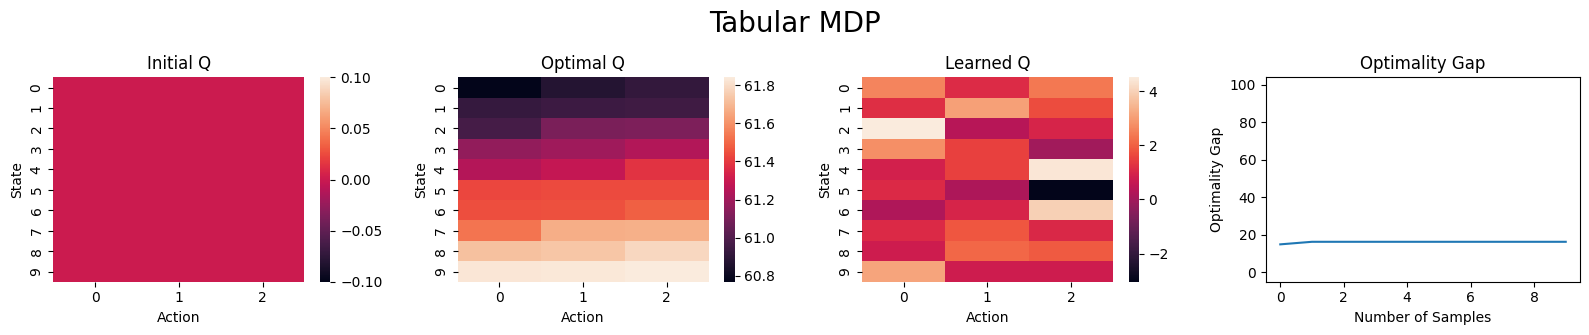

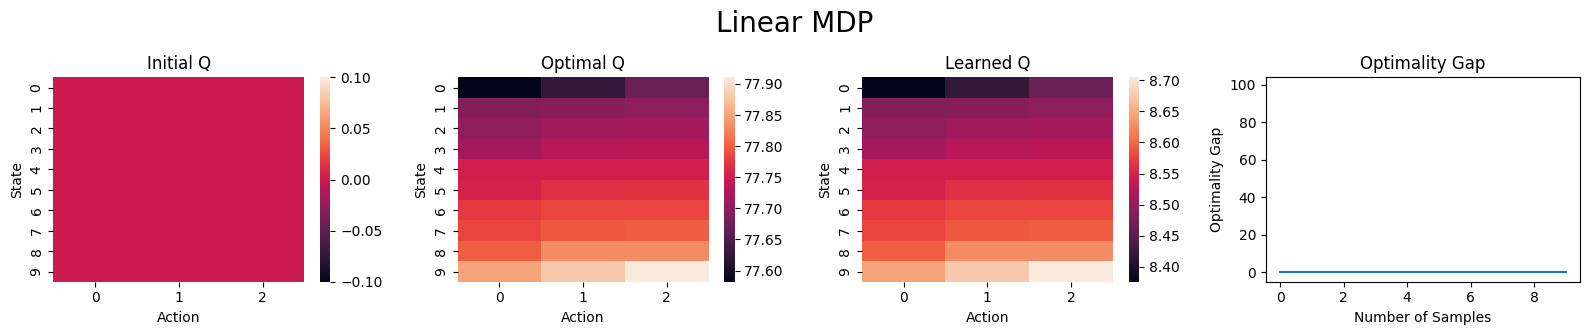

In [8]:
@jax.jit
def compute_targ_Q(mdp: MDP, Q: np.ndarray):
    S, A = Q.shape
    greedy_policy = compute_greedy_policy(Q)
    max_Q = np.sum(greedy_policy * Q, axis=1).reshape(1, 1, S)
    next_v = np.sum(mdp.P * max_Q, axis=-1)
    assert next_v.shape == (S, A)
    return mdp.rew + mdp.gamma * next_v


def do_linear_value_iteration(mdp: MDP, title: str):
    plt.figure(figsize=(16, 3))
    optimality_gaps = []
    S, A, d = mdp.S, mdp.A, mdp.d

    # >>>> Initialize Q >>>>
    Q_feature = np.zeros(d)
    pred_Q = lambda: mdp.phi @ Q_feature
    plt.subplot(1, 4, 1)
    plot_Q(pred_Q(), mdp, "Initial Q")
    # <<<< Initialize Q <<<<

    # >>>> Do value iteration >>>>
    for _ in range(10):
        targ_Q = compute_targ_Q(mdp, pred_Q())
        Q_feature = jnp.linalg.lstsq(mdp.phi.reshape(S * A, d), targ_Q.reshape(S * A))[0]
        greedy_policy = compute_greedy_policy(pred_Q())
        optimality_gaps.append(compute_optimality_gap(mdp, greedy_policy))
    # <<<< Do value iteration <<<<

    # >>>> Plot results >>>>
    plt.subplot(1, 4, 2)
    plot_Q(mdp.optimal_Q, mdp, "Optimal Q")

    plt.subplot(1, 4, 3)
    plot_Q(pred_Q(), mdp, "Learned Q")

    plt.subplot(1, 4, 4)
    plt.plot(optimality_gaps)
    plt.xlabel("Number of Samples")
    plt.ylabel("Optimality Gap")
    plt.ylim(-5, mdp.horizon + 5)
    plt.title("Optimality Gap")
    # <<<< Plot results <<<<

    plt.tight_layout()
    plt.suptitle(title, y=1.1, fontsize=20)

do_linear_value_iteration(table_MDP, "Tabular MDP")
do_linear_value_iteration(linear_MDP, "Linear MDP")

## 動的計画法で分かること


|   MDPの形式          | 線形関数近似 | テーブル形式 |
|-------------|--------------|--------------|
| Tabular MDP | 解けてない    |     解けた    |
| Linear MDP  | 解けた        |     解けた  |

テーブル形式の価値反復法はTabular MDPとLinear MDPのどちらも解けていますが、線形関数近似ではLinear MDPしか解けていません。つまり、どう頑張っても``この``線形近似器では``この``Tabular MDPは解けないことになります。

なぜLinear MDPが解けるのでしょうか？実は、Linear MDPの条件下では、任意の方策のQ関数を線形に表すことができます。つまり、どんな$\pi$についても、$q_\pi$を誤差０で回帰することができます (もちろん$q_*$もです)。

一方で、Tabular MDPでは$q_*$が回帰できない可能性があります。関数近似器の性能が悪いため、どんなに頑張っても悪いQ値しか出力できないのです。
この問題は、もっと表現力が高い関数近似器（$d ==100$ にしてみてください）で回避できます。

興味がある人は[参考文献](https://arxiv.org/abs/1907.05388)を見てください。


# 強化学習で解く

先程の動的計画法の実験では、線形関数近似とテーブル形式がそれぞれのMDPを解けるか実験してみました

どちらもLinear MDPが解けていますが、強化学習どれくらいの時間がかかるか確認してみましょう。

## 強化学習に便利な関数

次に強化学習の実験に移りますが、その前にいくつか便利な関数を導入します。

1. ``sample_next_state``: $(s, a)$の次の状態をサンプルします。
2. ``sample_init_state``: 初期状態をサンプルします。
3. ``sample_eps_greedy_act``: 与えられたQ値から、epsilon-greedy方策に従って行動を返します
4. ``ReplayBuffer``: リプレイバッファです

In [8]:
from tqdm import tqdm
import random


# >>>> 1 >>>>
def sample_next_state(mdp: MDP, s: int, a: int):
    """ sample next state according to the transition matrix P
    Args:
        mdp: MDP
        s: int
        a: int
    Returns:
        next_s: int
    """
    probs = np.array(mdp.P[s, a])
    return np.random.choice(mdp.S_array, p=probs)
# <<<< 1 <<<<


# >>>> 2 >>>>
def sample_init_state(mdp: MDP):
    return random.randint(0, mdp.S-1)
# <<<< 2 <<<<


# >>>> 3 >>>>
def sample_eps_greedy_act(mdp: MDP, q_s: np.array, eps: float):
    if random.random() < eps:
        return random.randint(0, mdp.A-1)
    else:
        return q_s.argmax()
# <<<< 3 <<<<


# >>>> 4 >>>>
class ReplayBuffer:
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def push(self, state, action, reward, next_state):
        data = (state, action, reward, next_state)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        states, actions, rewards, next_states = [], [], [], []
        for i in idxes:
            data = self._storage[i]
            state, action, reward, next_state = data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states)

    def sample(self, batch_size):
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)
# <<<< 4 <<<<

## Tabular Q-Learning

早速テーブルQ学習をしてみましょう。時間がかかりますが1000エピソード回してみます。

100%|██████████| 1000/1000 [01:07<00:00, 14.77it/s]


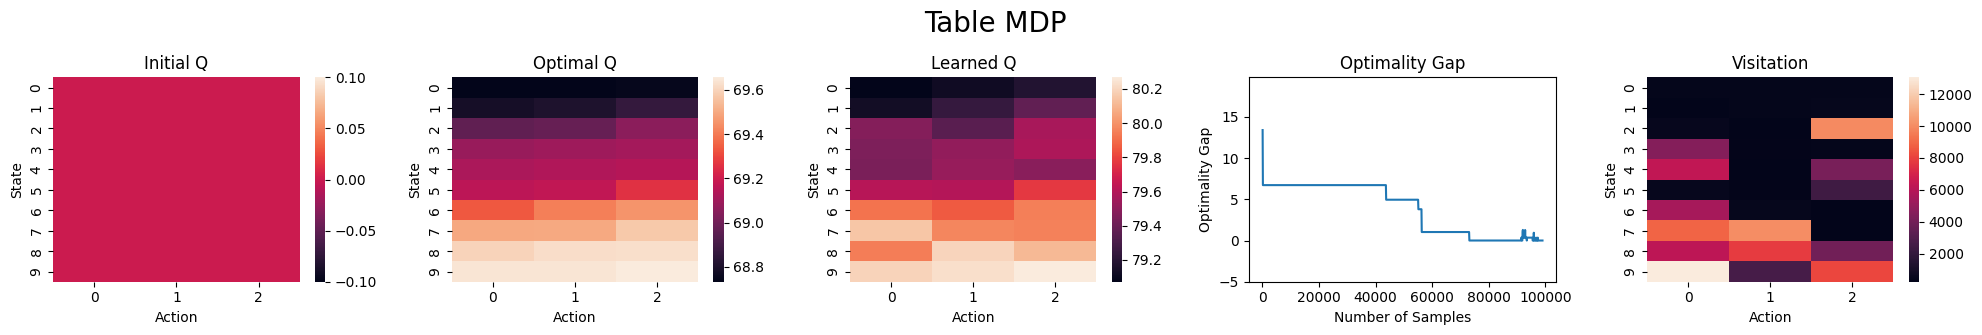

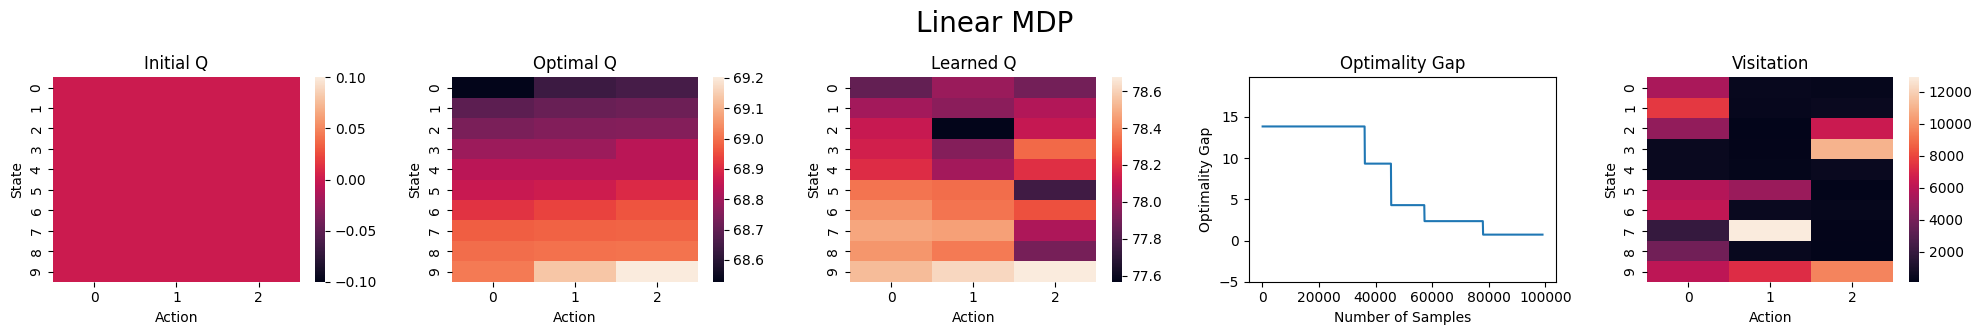

In [9]:
def do_Q_learning(mdp: MDP, title: str):
    plt.figure(figsize=(20, 3))
    tabular_Q_gaps = []
    S, A = mdp.S, mdp.A
    horizon = mdp.horizon

    # >>>> Initialize Q >>>>
    Q_table = np.zeros((S, A))
    visit_table = np.zeros((S, A))
    plt.subplot(1, 5, 1)
    plot_Q(Q_table, mdp, "Initial Q")
    # <<<< Initialize Q <<<<

    # >>>> Do Q learning >>>> 
    lr = 0.1

    tabular_Q_num_samples = []
    num_sample = 0

    for _ in tqdm(range(1000)):
        s = sample_init_state(mdp)
        for _ in range(horizon):
            a = sample_eps_greedy_act(mdp, Q_table[s], 0.1)
            visit_table[s, a] += 1
            next_s = sample_next_state(mdp, s, a)
            targ_q = mdp.rew[s, a] + mdp.gamma * Q_table[next_s].max()
            Q_table[s, a] = lr * targ_q + (1 - lr) * Q_table[s, a]
            s = next_s

            num_sample += 1

        greedy_policy = compute_greedy_policy(Q_table)
        tabular_Q_gaps.append(compute_optimality_gap(mdp, greedy_policy).max())
        tabular_Q_num_samples.append(num_sample)
    # <<<< Do Q learning <<<< 

    plt.subplot(1, 5, 2)
    plot_Q(mdp.optimal_Q, mdp, "Optimal Q")

    plt.subplot(1, 5, 3)
    plot_Q(Q_table, mdp, "Learned Q")

    plt.subplot(1, 5, 4)
    plt.plot(tabular_Q_num_samples, tabular_Q_gaps)
    plt.ylim(-5, mdp.horizon / 5)
    plt.xlabel("Number of Samples")
    plt.ylabel("Optimality Gap")
    plt.title("Optimality Gap")

    plt.subplot(1, 5, 5)
    plot_Q(visit_table, mdp, "Visitation")

    plt.tight_layout()
    plt.suptitle(title, y=1.1, fontsize=20)

    return tabular_Q_num_samples, tabular_Q_gaps

table_MDP_num_samples_table_Q, table_MDP_gaps_table_Q = do_Q_learning(table_MDP, "Tabular MDP")
linear_MDP_num_samples_table_Q, linear_MDP_gaps_table_Q = do_Q_learning(linear_MDP, "Linear MDP")

## Least-Squares Q Learning

100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 1000/1000 [03:07<00:00,  5.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


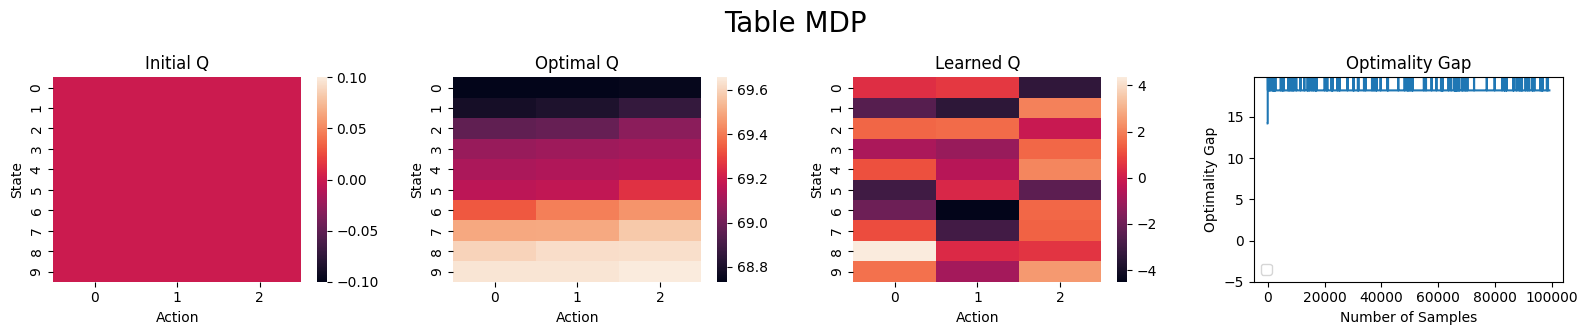

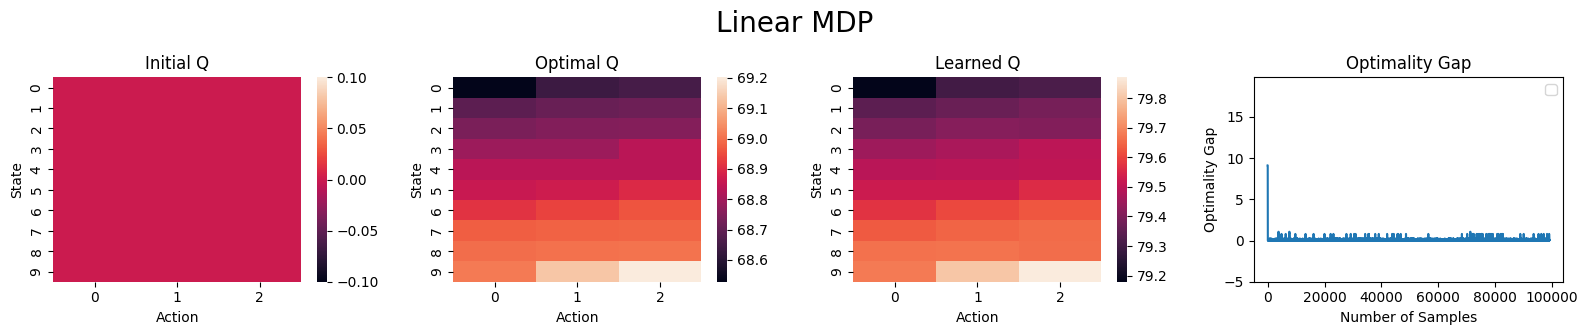

In [10]:
@jax.jit
def compute_new_Q_feature(Q: np.ndarray, batch_phi: np.ndarray, batch_r: np.ndarray, batch_next_s: np.ndarray):
    next_v = Q[batch_next_s].max(axis=1)
    targ_q = batch_r + gamma * next_v
    targ_q = jnp.minimum(targ_q, horizon)
    new_Q_feature = jnp.linalg.lstsq(batch_phi, targ_q)[0]
    return new_Q_feature


def do_ls_Q_learning(mdp: MDP, title: str):
    plt.figure(figsize=(16, 3))
    LS_Q_gaps = []

    # >>>> Initialize Q >>>>
    Q_feature = np.zeros(mdp.d)
    buffer = ReplayBuffer(10000)
    batch_size = 16

    pred_Q = lambda: mdp.phi @ Q_feature
    plt.subplot(1, 4, 1)
    plot_Q(pred_Q(), mdp, "Initial Q")
    # <<<< Initialize Q <<<<

    # >>>> Do Q learning >>>> 
    lr = 0.1
    LS_Q_num_samples = []
    num_sample = 0


    for t in tqdm(range(1000)):
      s = sample_init_state(mdp)
      for _ in range(horizon):
        Q = pred_Q()
        a = sample_eps_greedy_act(mdp, Q[s], 0.1)
        next_s = sample_next_state(mdp, s, a)
        r = mdp.rew[s, a]
        buffer.push(s, a, r, next_s)
        s = next_s
        num_sample += 1

        if len(buffer) > batch_size:
          batch_s, batch_a, batch_r, batch_next_s = buffer.sample(batch_size)
          batch_phi = mdp.phi[batch_s, batch_a]
          assert batch_phi.shape == (batch_size, d)
          new_Q_feature = compute_new_Q_feature(Q, batch_phi, batch_r, batch_next_s)
          assert new_Q_feature.shape == (d,)
          Q_feature = lr * new_Q_feature + (1 - lr) * Q_feature

        LS_Q_num_samples.append(num_sample)
        greedy_policy = compute_greedy_policy(pred_Q())
        LS_Q_gaps.append(compute_optimality_gap(mdp, greedy_policy))
    # <<<< Do Q learning <<<< 

    # >>>> Plot results >>>>
    plt.subplot(1, 4, 2)
    plot_Q(mdp.optimal_Q, mdp, "Optimal Q")

    plt.subplot(1, 4, 3)
    plot_Q(pred_Q(), mdp, "Learned Q")

    plt.subplot(1, 4, 4)
    plt.plot(LS_Q_num_samples, LS_Q_gaps)
    plt.ylim(-5, mdp.horizon / 5)
    plt.xlabel("Number of Samples")
    plt.ylabel("Optimality Gap")
    plt.title("Optimality Gap")
    plt.legend()

    plt.tight_layout()
    plt.suptitle(title, y=1.1, fontsize=20)
    # <<<< Plot results <<<<

    return LS_Q_num_samples, LS_Q_gaps


table_MDP_num_samples_ls_Q, table_MDP_gaps_ls_Q = do_ls_Q_learning(table_MDP, "Table MDP")
linear_MDP_num_samples_ls_Q, linear_MDP_gaps_ls_Q = do_ls_Q_learning(linear_MDP, "Linear MDP")

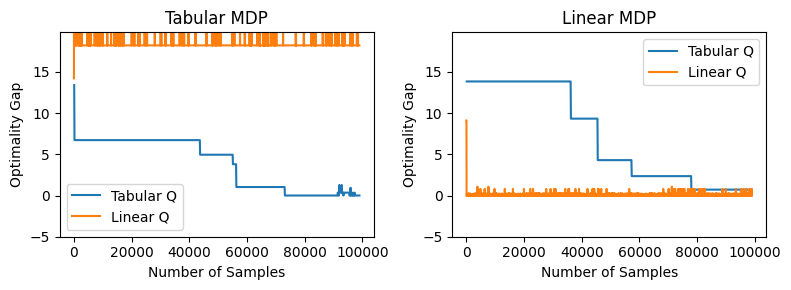

In [14]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(table_MDP_num_samples_table_Q, table_MDP_gaps_table_Q, label="Tabular Q")
plt.plot(table_MDP_num_samples_ls_Q, table_MDP_gaps_ls_Q, label="Linear Q")
plt.ylim(-5, table_MDP.horizon / 5)
plt.xlabel("Number of Samples")
plt.ylabel("Optimality Gap")
plt.title("Tabular MDP")
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(linear_MDP_num_samples_table_Q, linear_MDP_gaps_table_Q, label="Tabular Q")
plt.plot(linear_MDP_num_samples_ls_Q, linear_MDP_gaps_ls_Q, label="Linear Q")
plt.ylim(-5, linear_MDP.horizon / 5)
plt.xlabel("Number of Samples")
plt.ylabel("Optimality Gap")
plt.title("Linear MDP")
plt.legend()
plt.tight_layout()

## 強化学習で分かること

|   MDPの形式          | 線形関数近似 | テーブル形式 |
|-------------|--------------|--------------|
| Tabular MDP | 解けてない    |     解けた    |
| Linear MDP  | 100サンプル以下 |     解けた  |


テーブルMDPでは線形関数近似の表現力が足りずに学習が全くできませんが、Linear MDPではテーブルRLよりも圧倒的に早く学習ができていることがわかります。

驚くことに、探索をほとんどしなくても解けているのです。これは実世界応用では非常に重要です。なぜこんなに早く解けるのでしょうか？ Linear MDPの性質と照らし合わせて考えてみましょう。